In [2]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

from MotorNet.plants import PlantWrapper
from MotorNet.plants.skeletons import PointMass
from MotorNet.plants.muscles import RigidTendonHillMuscle, CompliantTendonHillMuscle
from MotorNet.utils.plotor import plot_pos_over_time

%load_ext autoreload
%autoreload 2

# tf.debugging.enable_check_numerics()
print('tensorflow version: ' + tf.__version__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensorflow version: 2.3.0


In [5]:
arm = PointMass(space_dim=2, proprioceptive_delay=0.04, visual_delay=0.13)
plant = PlantWrapper(skeleton=arm, muscle_type=CompliantTendonHillMuscle(), timestep=0.001)

plant.add_muscle(path_fixation_body=[0., 1.], path_coordinates=[[5., 0.], [0., 0.]], name='r_muscle',
                 max_isometric_force=500., optimal_muscle_length=2., tendon_length=3.)
plant.add_muscle(path_fixation_body=[0., 1.], path_coordinates=[[-5, 0.], [0., 0.]], name='l_muscle',
                 max_isometric_force=500., optimal_muscle_length=2., tendon_length=3.)

plant.Muscle.dt

0.001

simulation duration: 3.125 sec


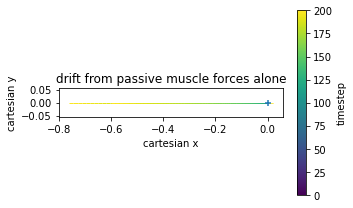

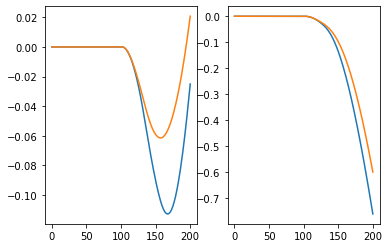

In [6]:
# create initial conditions
sho, elb = np.meshgrid(
    np.linspace(plant.pos_lower_bound[0], plant.pos_upper_bound[0], 21).astype('float32'),
    np.linspace(plant.pos_lower_bound[1], plant.pos_upper_bound[1], 21).astype('float32'))
z = tf.zeros_like(sho.reshape(-1))
state0 = plant.get_initial_state(joint_state=tf.zeros((4,4)))
endpoint_load = 0.

# 200 ms simulation to assess drift
c_results = state0[1][:, tf.newaxis, :]
m_results = state0[-2][:, tf.newaxis, :, :]
states = state0
start = time.monotonic()
for k in range(int(0.2 / arm.dt)):

    if k * arm.dt > 0.1:  # after 100 ms
        endpoint_load = np.array([-100,0])

    if k * arm.dt < 0.125:
        ex = tf.cast(np.array([[.02, .02], [.25, .25], [0.02, 0.02], [0.25, 0.25]]), dtype=tf.float32)
    elif k * arm.dt < 0.150:
        ex = tf.cast(np.array([[.27, .02], [.50, .02], [0.02, 1.], [0.02, 1.]]), dtype=tf.float32)
    else:
        ex = tf.cast(np.array([[.75, .02], [.75, .02], [0.02, 1.], [0.02, 1.]]), dtype=tf.float32)

    states = plant(ex, states[0], states[2], states[3], endpoint_load=endpoint_load)
    c_results = tf.concat([c_results, states[1][:, tf.newaxis, :]], axis=1)
    m_results = tf.concat([m_results, states[-2][:, tf.newaxis, :, :]], axis=1)


print('simulation duration: ' + str(time.monotonic() - start) + ' sec')

# plot results
plt.figure(figsize=(5, 3)).set_tight_layout(True)
plot_pos_over_time(cart_results=c_results)
plt.title('drift from passive muscle forces alone')
plt.show()

plt.subplot(121)
plt.plot(c_results[0, :, 0].numpy().T)
plt.plot(c_results[1, :, 0].numpy().T)

plt.subplot(122)
plt.plot(c_results[2, :, 0].numpy().T)
plt.plot(c_results[3, :, 0].numpy().T)

plt.show()


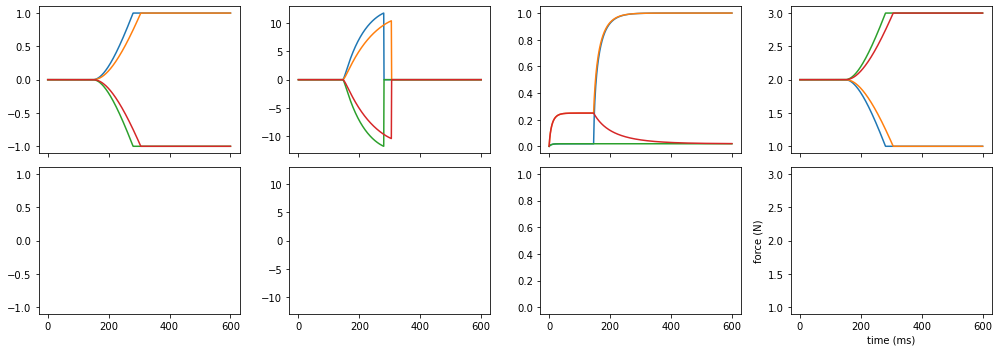

In [19]:
trial = 1

fig, axs = plt.subplots(nrows=2, ncols=4, sharex='col', sharey='col')
fig.set_tight_layout(tight=True)
fig.set_size_inches((14, 5))

axs[0,0].plot(c_results[:, :, 0].numpy().T.squeeze(), label='sho')
plt.xlabel('time (ms)')
plt.ylabel('angle (rad)')

axs[0,1].plot(c_results[:, :, 2].numpy().T.squeeze(), label='sho')
plt.xlabel('time (ms)')
plt.ylabel('angle velocity (rad/sec)')

axs[0,2].plot(m_results[:, :, 0, 0].numpy().T.squeeze())
plt.xlabel('time (ms)')
plt.ylabel('activation (a.u.)')

axs[0,3].plot(m_results[:, :, 1, 0].numpy().T.squeeze())
plt.xlabel('time (ms)')
plt.ylabel('force (N)')

plt.show()
